# Basic NN applied to the data

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
class JetDataset(Dataset):
    def __init__(self,file_name):
        df = pd.read_csv(file_name,sep=",")

        # need to check how this is being done
        y = df["RUL"].values
        df = df.drop("RUL",axis=1)
        x = df.iloc[:,:].values

        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]


In [3]:
training_data = JetDataset("../data/processed/processed_train_FD001.txt")
test_data = JetDataset("../data/processed/processed_test_FD001.txt")
train_dataloader = DataLoader(training_data,batch_size=10,shuffle=False)
test_dataloader = DataLoader(test_data,batch_size=1,shuffle=False)

print(training_data.x)

# outputs the detials of each mini-batch
# for X,y in train_dataloader:
#     print(f"Shape of X [N,F]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")

tensor([[ 0.0000e+00,  1.0000e+00, -7.0000e-04,  ...,  2.3419e+01,
          2.3419e+01,  1.0000e+00],
        [ 1.0000e+00,  1.0000e+00,  1.9000e-03,  ...,  2.3424e+01,
          2.3424e+01,  1.0000e+00],
        [ 2.0000e+00,  1.0000e+00, -4.3000e-03,  ...,  2.3344e+01,
          2.3344e+01,  1.0000e+00],
        ...,
        [ 2.0628e+04,  1.0000e+02,  4.0000e-04,  ...,  2.3192e+01,
          2.2933e+01,  9.9407e-01],
        [ 2.0629e+04,  1.0000e+02, -1.1000e-03,  ...,  2.3192e+01,
          2.2933e+01,  9.9981e-01],
        [ 2.0630e+04,  1.0000e+02, -3.2000e-03,  ...,  2.3192e+01,
          2.2933e+01,  9.9912e-01]])


In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(143, 60),
            nn.Sigmoid(),
            nn.Linear(60, 60),
            nn.Sigmoid(),
            nn.Linear(60, 1)
        )

    def forward(self, x):
        # x = self.flatten(x)
        val = self.linear_relu_stack(x)
        return val

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=143, out_features=60, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=60, out_features=1, bias=True)
  )
)


In [6]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Error: \n Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Trainig Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(train_dataloader, model, loss_fn)
print("Done!")

Trainig Epoch 1
-------------------------------


c:\Users\steve\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 34739.734375  [   10/20631]
loss: 12087.705078  [ 1010/20631]
loss: 16788.253906  [ 2010/20631]
loss: 7962.812500  [ 3010/20631]
loss: 25864.271484  [ 4010/20631]
loss: 10502.629883  [ 5010/20631]
loss: 45430.730469  [ 6010/20631]
loss: 18986.355469  [ 7010/20631]
loss: 1125.130615  [ 8010/20631]
loss: 1774.461182  [ 9010/20631]
loss: 12687.929688  [10010/20631]
loss: 60122.863281  [11010/20631]
loss: 13641.897461  [12010/20631]
loss: 11743.000000  [13010/20631]
loss: 14098.822266  [14010/20631]
loss: 21689.751953  [15010/20631]
loss: 15830.705078  [16010/20631]
loss: 19377.511719  [17010/20631]
loss: 4351.218262  [18010/20631]
loss: 16.991756  [19010/20631]
loss: 5671.788574  [20010/20631]


c:\Users\steve\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Error: 
 Avg loss: 14405.208952 

Trainig Epoch 2
-------------------------------
loss: 31363.474609  [   10/20631]
loss: 10077.562500  [ 1010/20631]
loss: 14351.084961  [ 2010/20631]
loss: 6281.242188  [ 3010/20631]
loss: 22676.958984  [ 4010/20631]
loss: 8468.066406  [ 5010/20631]
loss: 41001.273438  [ 6010/20631]
loss: 16100.675781  [ 7010/20631]
loss: 505.078674  [ 8010/20631]
loss: 946.315002  [ 9010/20631]
loss: 10192.544922  [10010/20631]
loss: 54398.199219  [11010/20631]
loss: 10934.518555  [12010/20631]
loss: 9190.013672  [13010/20631]
loss: 11199.219727  [14010/20631]
loss: 17984.240234  [15010/20631]
loss: 12636.242188  [16010/20631]
loss: 15738.889648  [17010/20631]
loss: 4061.961182  [18010/20631]
loss: 305.244537  [19010/20631]
loss: 3682.001465  [20010/20631]
Error: 
 Avg loss: 11725.643040 

Trainig Epoch 3
-------------------------------
loss: 26352.144531  [   10/20631]
loss: 7295.624023  [ 1010/20631]
loss: 10948.674805  [ 2010/20631]
loss: 4089.488037  [ 3010/20631]

In [10]:
def test_errors(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    errors = torch.Tensor(np.zeros((size,1))).to(device)
    index = 0
    num_batches = len(dataloader)
    assert size == num_batches,"Use batch size of 1 to use this function"  #make sure batch size of 1 to look at them individually
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            errors[index,0] = (pred - y)
            index = index + 1

    return errors


In [11]:
print("Evaluation of Test Error: ")
test(test_dataloader,model,loss_fn)

errors = test_errors(test_dataloader,model,loss_fn)

Evaluation of Test Error: 
Error: 
 Avg loss: 9038.033670 

tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.7110]], device='cuda:0')
tensor([[66.711

Text(0.5, 0, '$|RUL_{Predicted} - RUL_{Expected}|$')

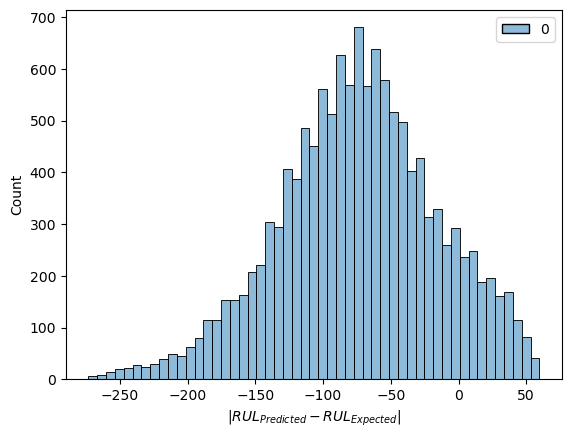

In [12]:
import seaborn as sns

ax = sns.histplot(errors.cpu())
ax.set_xlabel(r"$|RUL_{Predicted} - RUL_{Expected}|$")

In [13]:
input = torch.randn(1, 1, 1, 143)
input = input.to(device)
predict = model(input)
print(predict)

tensor([[[[59.6051]]]], device='cuda:0', grad_fn=<AddBackward0>)
